In [4]:
import numpy as np
import pandas as pd
import time 
import matplotlib.pyplot as plt

In [5]:
import tensorflow as tf
from keras.layers import Dense , Activation , Dropout, Embedding, SpatialDropout1D, LSTM , TextVectorization, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam

2023-04-19 01:02:06.984161: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-19 01:02:06.984225: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [6]:
import torch

In [7]:
from bs4 import BeautifulSoup
import os
import re

In [8]:
directory = 'corpus_morphological_analysis'
file_paths = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    file_paths.append(f)    

In [97]:
temp_file_paths = file_paths[:1000]

In [98]:
content = []
#i = 0
for filepath in temp_file_paths :
    #print(i)
    with open(filepath, encoding='utf-8') as f :
        html = f.read()
    soup = BeautifulSoup(html, features="html.parser")
    for script in soup(["script", "style"]):
        script.extract()  
    text = soup.get_text()
    content.append(text)
    #i+=1

In [101]:
split_list = []
for item in content : 
    tmp = item.splitlines()
    split_list.append(tmp)

In [102]:
work_list = []
for k in split_list :
    l = [item for item in k if 'لا توجد نتائج لتحليل هذه الكلمة' not in item]
    tmp_l = [item.replace("#",'') for item in l]
    work_list.append(tmp_l)

In [103]:
final_list = []
for k in work_list :
    tst = [item.split(':') for item in k]
    final_list.append(tst)

In [104]:
# identifie le prefixe, racine et le suffixe et les placent dans un dictionnaire
def identify(word_l):
    if len(word_l) < 4 :
        return None
    dictt = {}
    dictt['word'] = word_l[0]
    # le cas s'il existe un préfixe
    if word_l[2] != '' and word_l[2] != ' ' :   
        if word_l[4] not in word_l[0]: 
            if word_l[5] in word_l[0] and word_l[5] != '': 
                dictt['prefixe'] = word_l[2]
                dictt['root'] = word_l[8]
                dictt['suffixe'] = word_l[9]
            elif word_l[3] in word_l[0] and word_l[3] != '':
                dictt['prefixe'] = word_l[2]
                dictt['root'] = word_l[3]
                dictt['suffixe'] = ''
        else :
            dictt['prefixe'] = word_l[2]
            dictt['root'] = word_l[7]
            dictt['suffixe'] = word_l[8]
    # s'il n'existe pas un préfixe
    else : 
        if word_l[2] == '' : 
            dictt['prefixe'] = word_l[2]
            dictt['root'] = word_l[6]
            dictt['suffixe'] = word_l[7]
        elif  word_l[2] == ' ' :
            dictt['prefixe'] = ''
            dictt['root'] = word_l[3]
            dictt['suffixe'] = ''    
    return dictt

In [105]:
# filtre la liste de mots en liste de dictionnaires
def word_to_dict_list(wordlist):
    dictlist = []
    for k in wordlist : 
        dictlist.append(identify(k))
    return dictlist

In [106]:
final = []
for k in final_list: 
    for j in k :
        s = identify(j)
        if s == None :
            continue
        final.append(identify(j))

In [111]:
def dic_to_list(listt):
    L = []
    for k in listt : 
        tmp = []
        #print(k)
        if len(k) == 4 : 
            tmp.append(k['word'])
            tmp.append(k['prefixe'])
            tmp.append(k['root'])
            tmp.append(k['suffixe'])
            L.append(tmp)
    return L
data = dic_to_list(final)

In [112]:
final_l = dic_to_list(final)
final_l[0]

['مسقط', '', 'سقط', '']

In [113]:
# experimenting with our first neural network to predict the root of a word.

data_1 = []

for word in final_l:
    tmp = []
    word[0] = word[0].replace('+', ' ')
    word[2] = word[2].replace('+', ' ')
    tmp.append(word[0])
    tmp.append(word[2])
    data_1.append(tmp)
    #print(tmp)
#data_1

In [114]:
# we extract our dictionnary from the our dataset 
def extract_dict(listt) :
    dictt = []
    for word in listt :
        for item in word : 
            tmp = set(item)
            for k in tmp : 
                if k not in dictt : 
                    dictt.append(k)
    return dictt       
dic = extract_dict(data_1)

In [115]:
root_data = []
for word in data : 
    tmp =[]
    tmp.append(word[0])
    tmp.append(word[2])
    root_data.append(tmp)
#root_data

In [24]:
class encode :
    
    def __init__(self, data):
        self.data = data
        
    def code_sequence(self):
        L = []
        for word in self.data : 
            tmp_string = code_word(word)
            L.append(tmp_string)
        final_string = '#'.join(map(str,L))
        return final_string 
    
    def code_normal_text(self):
        L = []
        for word in self.data : 
            L.append(word[1])
        final_string = ' '.join(map(str,L))
        return final_string
        
final_str = encode(root_data).code_normal_text()      

In [117]:
len(data_root)

397396

In [116]:
data_root = []
for item in root_data : 
    tmp = []
    if len(item[1]) <= 3 and len(item[1]) != 0:
        tmp.append('$'+item[0]+'£')
        tmp.append('$'+item[1]+'£')
        data_root.append(tmp)

In [26]:
def data_padding(dat, padding_char):
    #Le'ts create a padding character : 
    pad_char = padding_char
    padded_data = []
    
    ls_words = []
    ls_roots = []

    for instance in dat : 
        ls_words.append(instance[0])
        ls_roots.append(instance[1])
    max_len_words = max([len(item) for item in ls_words])
    max_len_roots = max([len(item) for item in ls_roots])
    
    for instance in dat: 
        tmp = []
        word,root = instance[0], instance[1]
        while(len(word) != max_len_words):
            word += pad_char
        tmp.append(word)
        while(len(root) != max_len_roots):
            root += pad_char
        tmp.append(root)
        padded_data.append(tmp)
        
    return padded_data

In [27]:
data_padding(data_root,'%')[:10]

[['$مسقط£%%%%%%%%', '$سقط£'],
 ['$يقام£%%%%%%%%', '$قمي£'],
 ['$الرابع£%%%%%%', '$ربع£'],
 ['$والعشرين£%%%%', '$عشر£'],
 ['$من£%%%%%%%%%%', '$من£%'],
 ['$شهر£%%%%%%%%%', '$شهر£'],
 ['$فبراير£%%%%%%', '$رير£'],
 ['$المقبل£%%%%%%', '$قبل£'],
 ['$قصر£%%%%%%%%%', '$قصر£'],
 ['$البستان£%%%%%', '$بسس£']]

In [28]:
    
    def train_batch(self, batch):
                
        self.optimizer.zero_grad()
        for instance in batch: 
            '''
            word = instance[0] : the word to extract root from
            target_word = instance[1] : the root of the word
            '''
            word = instance[0]
            target_root = instance[1]
            
            res1 = self.encode_word(word)
            predicted_root = []
            original_root_seq = self.word_to_idx_seq(target_root)
            predicted_root_seq = []
            res_char = target_root[0]
            
            i = 0
            for char in target_root : 
                if len(predicted_root) == len(target_root):
                    break
                
                
                if random.random() < self.teacher_forcing_ratio and i!=0 : 
                    res_char = char
                    i+= 1
                
                res_char , hidd , idx = self.decode_word(res1, res_char)
                predicted_root_seq.append(idx)
                test = hidd
                predicted_root.append(res_char)

            predicted_root = ''.join(predicted_root)

            predicted_root_seq = torch.tensor(predicted_root_seq)

            org = self.embedding(original_root_seq)
            pred = self.embedding(predicted_root_seq)
            
            
            loss = self.criterion(org, pred)
            
            loss.backward()

            print('target root :', target_root)
            print('predicted root : ', predicted_root)

            print('the loss : ', loss.item())  
        self.optimizer.step()
        
        return
    
            
            
        #print(em1)
        

In [29]:
def prepare_data(self):
    
    #Le'ts create a padding for ouriinstances : 
    
    pad_char = ''
    padded_data = []
    ls_words = []
    ls_roots = []
    for instance in self.data : 
        ls_words.append(instance[0])
        ls_roots.append(instance[1])
    max_len_words = max([len(item) for item in ls_words])
    max_len_roots = max([len(item) for item in ls_roots])
    
    for instance in self.data: 
        tmp = []
        word,root = instance[0], instance[1]
        while(len(word) != max_len_words):
            word += pad_char
        tmp.append(word)
        while(len(root) != max_len_roots):
            root += pad_char
        tmp.append(root)
        padded_data.append(tmp)
    

    # let's create our vocab : 
    
    vocab = []
    for word in padded_data :
        for item in word : 
            tmp = set(item)
            for k in tmp : 
                if k not in vocab : 
                    vocab.append(k)
    
    
    # Let's create our dictionnary with unique indexes
    
    char_to_idx_map = {char: idx for idx, char in enumerate(dictt)}
    
    # Let's now split our data to batches
   
    final_data = []
    for instance in padded_data : 
        tmp = []
        word = self.word_to_seq(instance[0])
        root = self.word_to_seq(instance[1])
        tmp.append(word)
        tmp.append(root)
        final_data.append(tmp)
        
    size= self.batch_size 
    batches = [final_data[i:i + size] for i in range(0, len(final_data), size)]
    
    return batches , vocab , char_to_idx_map

In [93]:
# implementation of a paper : 

import tensorflow as tf
import numpy as np
import torch.nn as nn
import torch 
import string
import torch.optim as optim
import random


class model(nn.Module): 
    
    # (data,
    
    def __init__(self, data, batch_size ,embedding_size, num_layers,dropout, teacher_forcing_ratio, learning_rate):
        super().__init__()
        
        '''
        our input data are arabic words with their roots, with the hypothesis that each word has it's own root.
        
        (our dataset for this is named root_data)
        '''
        self.lr = learning_rate
        self.ratio = 0.75
        self.batch_size = batch_size
        self.data = data
        self.batches, self.vocab, self.char_index_dic = self.prepare_data(self.data)
        self.embedding_size = embedding_size
        self.hidden_size = len(self.vocab)
        self.num_layers = num_layers
        self.dropout = dropout
        self.embedding = nn.Embedding(num_embeddings = len(self.vocab), embedding_dim = self.embedding_size, padding_idx = self.char_index_dic['%']) 
        
        
        #self.bigru = nn.GRU(input_size=self.embedding_size, hidden_size=self.hidden_size, num_layers=self.num_layers, bidirectional=True, batch_first=True)
        
        self.BILSTM = nn.LSTM(input_size=self.embedding_size, hidden_size=self.hidden_size, num_layers=self.num_layers, bidirectional=True, batch_first=True, dropout = self.dropout)

        
        #self.gru = nn.GRU(input_size= self.embedding_size ,hidden_size = self.hidden_size * 2, num_layers = self.num_layers, batch_first = True)
        self.LSTM = nn.LSTM(input_size= self.embedding_size ,hidden_size = self.hidden_size*2, num_layers = int(self.num_layers / self.num_layers), batch_first = True)

        
        self.criterion = nn.CrossEntropyLoss(ignore_index =self.char_index_dic['%'])
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.Linear = nn.Linear(self.hidden_size * 2,len(self.vocab))
        
        #self.optimizer = optim.Adam([*self.bigru.parameters(), *self.gru.parameters(), *self.Linear.parameters()], lr = 0.001)
        #self.optimizer = optim.Adam([*self.BILSTM.parameters(), *self.LSTM.parameters()], lr = 0.1)
        self.optimizer = optim.Adam(self.parameters(), lr = self.lr)

    
    def prepare_data(self, data):
    
        #Le'ts create a padding for ouriinstances : 

        pad_char = '%'
        padded_data = []
        ls_words = []
        ls_roots = []
        for instance in data : 
            ls_words.append(instance[0])
            ls_roots.append(instance[1])
        
        # Let's calculate the biggest length
        max_len_words = max([len(item) for item in ls_words])
        max_len_roots = max([len(item) for item in ls_roots])

        # Now we pad the word until we reach the max length
        for instance in data: 
            tmp = []
            word,root = instance[0], instance[1]
            while(len(word) != max_len_words):
                word += pad_char
            tmp.append(word)
            while(len(root) != max_len_roots):
                root += pad_char
            tmp.append(root)
            padded_data.append(tmp)

        # let's create our vocab : 

        vocab = []
        for word in padded_data :
            for item in word : 
                tmp = set(item)
                for k in tmp : 
                    if k not in vocab : 
                        vocab.append(k)

        # Let's create our dictionnary with unique indexes

        char_to_idx_map = {char: idx for idx, char in enumerate(vocab)}

        # Let's now split our data to batches

        final_data = []
        for instance in padded_data : 
            tmp = []
            word = [char_to_idx_map[char] for char in instance[0]]
            root = [char_to_idx_map[char] for char in instance[1]]
            tmp.append(word)
            tmp.append(root)
            final_data.append(tmp)

        size= self.batch_size 
        batches = [final_data[i:i + size] for i in range(0, len(final_data), size)]
        
        return batches , vocab , char_to_idx_map
    
    
    def word_to_seq(self, word):
        '''
        this function returns a sequence of the unique indexes for the given word 
        (sequence is tensor that can be changed using a .tolist() )
        '''
        word_char_idx_seq =[self.char_index_dic[char] for char in word]    
        return word_char_idx_seq # word sequence
    
    
    # Let's now construct our model : 
    
    # we should think about character embeddings in order to create an embeded matrix for each word
        
    
    
    def encode(self, batch):    
        '''
        input : a batch of sequences of instances : [word_seq , root_seq] * batch_size
                input_size : (input_size,2)
        '''
        
        word_batch = [] # list of words in the batch
        root_batch = [] # list of roots in the batch
        
        for instance in batch : 
            word_batch.append(instance[0])
            root_batch.append(instance[1])
            
        word_batch = torch.tensor(word_batch)
        root_batch = torch.tensor(root_batch)
        
        # we create embedding of the word batch : 
        
        embedded_word_batch = self.embedding(word_batch)
                
        outputs, (hidden, cell) = self.BILSTM(embedded_word_batch) # we pass the emebedded vector through the bi-GRU 
        # we take the last layer input : 
        
        hid , ce = hidden[-2:, :, :] , cell[-2:, :, :]
                        
        final_hidden = torch.unsqueeze(torch.cat((hid[0], hid[1]), dim = 1), 0)
        final_cell = torch.unsqueeze(torch.cat((ce[0], ce[1]), dim = 1), 0)
            
        return root_batch , (final_hidden, final_cell)
    

    
    
    def decode(self, encoder_hidden_cell , batch, teacher_forcing_bool):
        
        '''
        input : encoding_hidden_layer => corresponds to the concatenation of the final hidden layers 
                                        of the bidirectionnal gru in our encoder
                
                batch : subset of data that contains the roots of the words we encoded.
                
        output : we'll see :) 
        
        '''

        (hidden_layer , cell) , root_batch = encoder_hidden_cell , batch 
                        
        embedded_char = self.embedding(torch.unsqueeze(root_batch[:, 0], 1))
            
        outputs = []
        
        for i in range(root_batch.size(1)): 
            
            decoder_output , (hidden_layer, cell) = self.LSTM(embedded_char, (hidden_layer, cell))
                        
            input_dense = nn.Linear(self.hidden_size * 2,self.embedding_size)
            input_decoder_output = input_dense(decoder_output)
            
            embedded_char = input_decoder_output
        

            mask = np.where([random.random() < self.teacher_forcing_ratio for i in range(root_batch.size(0))])[0]
            
            teacher_forcing_input = self.embedding(torch.unsqueeze(torch.clone(root_batch[:, i]), 1))
            
            if teacher_forcing_bool : 

                embedded_char[mask] = teacher_forcing_input[mask] 
                
            Dense_decoded_output = self.Linear(decoder_output)
            outputs.append(Dense_decoded_output)

        return outputs 
                            
        
    
    def train_model(self, batches, teacher_forcing_bool):
                
        train_batches = batches        
         
        epoch_loss = 0
        
        n = 0            
        
        for batch in train_batches :

            self.optimizer.zero_grad()

            root_batch, encoder_states = self.encode(batch)

            outputs = self.decode(encoder_states, root_batch, teacher_forcing_bool)

            a = [torch.squeeze(item, 1) for item in outputs]
            a = [torch.unsqueeze(item, 0) for item in a]

            output = torch.cat(a, dim = 0)

            output_dim = output.shape[-1]

            output = output[1:].view(-1, output_dim)

            trg = root_batch.transpose(0, 1)

            trg = trg[1:].reshape(-1)

            loss = self.criterion(output, trg)

            loss.backward()

            torch.nn.utils.clip_grad_norm_(self.parameters(), 1)

            self.optimizer.step()

            epoch_loss+=loss.item()

            n+=1

            print('the loss of the train batch ', n ,' is : ', loss.item())
    
        return epoch_loss/n

    def evaluate_model(self, batches, teacher_forcing_bool):
        '''
        this method evaluates our model :=)
        will be similar to train but without the teacher forcing/ using an optimizer 
        '''          
        self.eval()

        val_batches = batches

        n = 0

        epoch_loss = 0
        
        with torch.no_grad() :

            for batch in val_batches :

                root_batch, encoder_states = self.encode(batch)

                outputs = self.decode(encoder_states, root_batch, teacher_forcing_bool)

                a = [torch.squeeze(item, 1) for item in outputs]
                a = [torch.unsqueeze(item, 0) for item in a]

                output = torch.cat(a, dim = 0)

                output_dim = output.shape[-1]

                output = output[1:].view(-1, output_dim)

                trg = root_batch.transpose(0, 1)

                trg = trg[1:].reshape(-1)

                loss = self.criterion(output, trg)

                epoch_loss+=loss.item()

                n+=1

                print('the loss of the val batch ', n ,' is : ', loss.item())

        return epoch_loss / n

    def fit(self, num_epochs):
        
        """
        let's first prepare our data
        
        """
        
        data = self.data
        
        data = random.sample(data, len(data))
        data_size = len(data)
        middle_index = int(data_size * self.ratio)        
        train_data , val_data = data[:middle_index], data[middle_index:]
        
        train_batches, voc, dic = self.prepare_data(train_data)
        val_batches ,voc , dic = self.prepare_data(val_data)
        
        epochs = list(range(num_epochs))
        
        best_val_loss = 1000
        best_model_par = 0
        
        losses =[]
        
        for epoch in epochs : 
            
            print('epoch num : ', epoch) 
            
            t1 = time.time()
            
            #train_batches = random.sample(train_batches , len(train_batches))
            #val_batches = random.sample(val_batches, len(val_batches))
                        
            train_loss = self.train_model(train_batches, 1)
            val_loss = self.evaluate_model(val_batches, 0) # we set the teacher forcing to false
            tmp = [train_loss , val_loss]
            losses.append(tmp)
            
            t2 = time.time()
            
            tmp = [train_loss, val_loss]
            losses.append(tmp)
            
            print('the training loss : ', train_loss , 'the val loss :', val_loss)
            print('epoch num : ' ,epoch , ' lasted : ', t2 - t1 , 'seconds')
            
            if val_loss < best_val_loss :
                
                best_val_loss = val_loss 
                best_model_par = self.state_dict()
            
            torch.save(best_model_par, 'best_model.pt')
            
        return losses
    

In [123]:
mod = model(data_root, 1000, 39, 8, 0.1 ,0.3, 0.01)
res = mod.fit(10)*

SyntaxError: invalid syntax (1916736936.py, line 2)

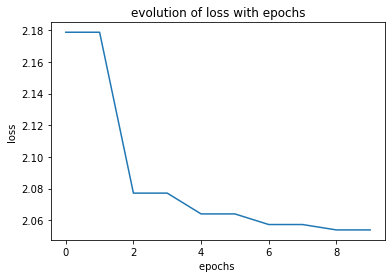

In [120]:
res = np.array(res)
plt.figure()
x = list(range(10))
plt.plot(x, res[:,0])
#plt.plot(x, res[:,1])
plt.title("evolution of loss with epochs")
plt.xlabel('epochs ')
plt.ylabel('loss')
plt.show()

In [ ]:
'''temp_soft = tuple(temp_soft)
        
        res = torch.tensor(res)
        
        tst = torch.cat(temp_soft, dim = 1)      
        
        predicted_sequences = []

        for instance in tst :

            best_char_indexes = [torch.argmax(item).item() for item in instance]

            predicted_sequences.append(best_char_indexes)

        #print(torch.tensor(predicted_sequences).size(), '*'*100)
        
        char_batch = torch.tensor(predicted_sequences)
        
        #print(char_batch)
                
        #print('predicted : ', predicted_roots.size(), 'original :', root_batch.size())           
        
        key_list = list(self.char_index_dic.keys())
        val_list = list(self.char_index_dic.values())

        pos_all = []

        for seq in char_batch : 

            positions = [val_list.index(item) for item in seq]
            result_chars = [key_list[pos] for pos in positions]
            char = ''.join(result_chars)

            pos_all.append(char)

        #print(pos_all)
                
        return root_batch , res , pos_all
    '''

In [ ]:
# implementation of a paper : 

import tensorflow as tf
import numpy as np
import torch.nn as nn
import torch 
import string
import torch.optim as optim
import random


class model(nn.Module): 
    
    def __init__(self, data, batch_size ,embedding_size, hidden_size, num_layers, teacher_forcing_ratio):
        super().__init__()
        
        '''
        our input data are arabic words with their roots, with the hypothesis that each word has it's own root.
        
        (our dataset for this is named root_data)
        '''
        self.sow = '$' # the start of root character 
        self.eow = '£' # the end of root character
        self.batch_size = batch_size
        self.data = data
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.vocab = self.extract_dict()
        self.char_index_dic = self.char_to_index()
        print(self.char_index_dic)
        self.num_layers = num_layers
        self.embedding = nn.Embedding(num_embeddings = len(self.vocab), embedding_dim = self.embedding_size) 
        self.bigru = nn.GRU(input_size=self.embedding_size, hidden_size=self.hidden_size, num_layers=self.num_layers, bidirectional=True)
        self.gru = nn.GRU(input_size= self.embedding_size ,hidden_size = self.hidden_size, num_layers = self.num_layers)
        self.criterion = nn.CrossEntropyLoss()
        self.teacher_forcing_ratio = teacher_forcing_ratio
        self.Linear = nn.Linear(self.hidden_size,len(self.vocab))
        self.optimizer = optim.Adam([*self.bigru.parameters(), *self.gru.parameters(), *self.Linear.parameters()], lr = 0.1)

    
    def extract_dict(self) :
        '''
        this function extracts all the unique characters from the given dataset
        '''
        dictt = []
        for word in self.data :
            for item in word : 
                tmp = set(item)
                for k in tmp : 
                    if k not in dictt : 
                        dictt.append(k)
        return dictt 
    
    
    # Let's now construct our model : 
    
    # we should think about character embeddings in order to create an embeded matrix for each word
    
    def char_to_index(self):
        '''
        this function creates unique indexes of each character
        '''
        char_to_idx_map = {char: idx for idx, char in enumerate(self.vocab)}
        return char_to_idx_map  
    
    def data_batches(self): 
        size = self.batch_size
        
        batches = [self.data[i:i + size] for i in range(0, len(self.data), size)]
        
        return batches
        
    
    def word_to_idx_seq(self, word):
        '''
        this function returns a sequence of the unique indexes for the given word 
        (sequence is tensor that can be changed using a .tolist() )
        '''
        word_char_idx_tensor = torch.tensor([self.char_index_dic[char] for char in word])        
        return word_char_idx_tensor # word sequence
    
    def word_to_seq(self, word):
        '''
        this function returns a sequence of the unique indexes for the given word 
        (sequence is tensor that can be changed using a .tolist() )
        '''
        word_char_idx_tensor =[self.char_index_dic[char] for char in word]    
        return word_char_idx_tensor # word sequence
    
    
    def encode_word(self, word):
        
            
        # we create embedding of the sequence : 
        word_seq = self.word_to_idx_seq(word)
        embedded_vec = self.embedding(word_seq)
        
        outputs, hidden = self.bigru(embedded_vec) # we pass the emebedded vector through the bi-GRU 

        
        '''
        kaynin two cases : 
        
             case1 :  we work on the outputs  ==> chosen
             case2 :  we work on the final hidden state ==> discarted 
            
        '''
        
        
        '''test_hidden = torch.flatten(hidden)
        final_hidden = torch.unsqueeze(test_hidden, 0)'''
        
        
        # can also be outputs.
        
        encoder_output = torch.mean(hidden , dim=0)  # Average the hidden vectors across all time steps. Shape: (hidden_size*2,) if bidirectional, else (hidden_size,)
        
        final_output = torch.unsqueeze(encoder_output, 0)
               
        
        return final_output
    
    
    def decode_word(self, encoding, character):

        
        '''
        encoding : output of the encoder network. 
        
        '''
        
        seq = self.word_to_idx_seq(self.sow)
        embedded_sow= self.embedding(self.word_to_idx_seq(character))   # starts with self.sow

        input_size = embedded_sow.size(1)

        hidden_size = encoding.size(1)
                 
        dec_out , dec_hidden = self.gru(embedded_sow,encoding)
                
        a = self.Linear(dec_out)
        m = nn.Softmax(dim = 1)
        
        output = m(a)
        
        top1 = output.argmax(1)[0].item()
        
        key_list = list(self.char_index_dic.keys())
        val_list = list(self.char_index_dic.values())

        position = val_list.index(top1)
        
        result_char = key_list[position]

        return result_char, dec_hidden , top1
        
        
    def train_batch(self, batch):
                
        
        for instance in batch: 
            '''
            word = instance[0] : the word to extract root from
            target_word = instance[1] : the root of the word
            '''
            word = instance[0]
            target_root = instance[1]
            
            hidd = self.encode_word(word)
            predicted_root = []
            original_root_seq = self.word_to_idx_seq(target_root)
            predicted_root_seq = []
            res_char = target_root[0]
            for char in target_root : 
                if len(predicted_root) == len(target_root):
                    break
                
                
                if random.random() < self.teacher_forcing_ratio : 
                    res_char = char
                
                res_char , hidd , idx = self.decode_word(hidd, res_char)
                predicted_root_seq.append(idx)
                test = hidd
                predicted_root.append(res_char)

            predicted_root = ''.join(predicted_root)

            predicted_root_seq = torch.tensor(predicted_root_seq)

            org = self.embedding(original_root_seq)
            pred = self.embedding(predicted_root_seq)
            
            self.optimizer.zero_grad()
            loss = self.criterion(org, pred)
            
            loss.backward()
            self.optimizer.step()

            print('target root :', target_root)
            print('predicted root : ', predicted_root)

            print('the loss : ', loss.item())        
        
        return None
    
    
    def train(self):
        
        batches = self.data_batches()
        
        for batch in batches : 
            
            self.train_batch(batch)

        #print(em1)
        
        

mod = model(data_root, 100, 50, 100, 1, 0.9)
mod.train()*

In [ ]:
'''l = 0
for item in root_data:
    if len(item[1]) > 3:
        print(item[1])'''

In [ ]:
'''def decode_word(self, word):
        
        hidden_size = 32  # Number of hidden units in the GRU
        num_layers = 1  # Number of layers in the GRU
        dropout = 0.2  # Dropout rate
        
        gru = nn.GRU(input_size=self.embedding_size, hidden_size=hidden_size, batch_first=True)
        
        e = self.encode_word(word)
        # Initialize the hidden state h0
        
        h0 = torch.zeros(1, hidden_size)

        
        # Concatenate the encoder representation and start-of-word character
        print(e.size())
        print(self.hsowi.unsqueeze(1).size())
        
        x = torch.cat([self.hsowi.unsqueeze(0).float(), e.unsqueeze(0)], dim=1)

        print(x.size())
        print(h0.size())
        
        # Apply the GRU layer
        out, h = gru(x)
        
        # Apply the output layer
        out_l = nn.Linear(hidden_size, len(self.vocab))
        
        out = out_l(out)
        
        softmax = nn.Softmax(dim=2)
        
        # Apply the softmax activation function
        out = softmax(out)
        
        return out
    '''

In [ ]:
'''import torch
import torch.nn as nn


class model:
    def __init__(self, data, embedding_size):
        self.sow = '$'  # the start of word character
        self.eow = '£'  # the end of word character
        self.data = data
        self.embedding_size = embedding_size
        self.vocab = self.extract_dict()
        self.char_index_dic = self.char_to_index()
        self.embedding = nn.Embedding(num_embeddings=len(self.vocab), embedding_dim=self.embedding_size)

    def extract_dict(self):
        dictt = []
        for word in self.data:
            for item in word:
                tmp = set(item)
                for k in tmp:
                    if k not in dictt:
                        dictt.append(k)
        dictt.append(self.sow)
        dictt.append(self.eow)
        return dictt

    def char_to_index(self):
        char_to_idx_map = {char: idx for idx, char in enumerate(self.vocab)}
        #print(char_to_idx_map)
        return char_to_idx_map

    def word_to_idx_seq(self, word):
        word_char_idx_tensor = torch.tensor([self.char_index_dic[char] for char in word])
        return word_char_idx_tensor

    def encode_word(self, word):
        
        hidden_size = 32
        bidirectional = True
        num_layers = 1
        
        
        gru = nn.GRU(input_size=self.embedding_size, hidden_size=hidden_size, num_layers=num_layers,
                     bidirectional=bidirectional, batch_first=True)

        
        
        word_seq = self.word_to_idx_seq(word)
        embedded_vec = self.embedding(word_seq)
        outputs, hidden = gru(embedded_vec)

        h1 = torch.reshape(hidden[-1], (1, hidden_size))
        h2 = torch.reshape(hidden[-2], (1, hidden_size))
        hidden = torch.cat((h2, h1), 1)

        encoder_output = torch.mean(hidden, dim=0)

        return encoder_output

    def decode_word(self, encoding):
        input_size = encoding.shape[-1] + len(self.vocab)
        hidden_size = 64
        num_layers = 1

        embedded_sow = self.embedding(torch.tensor(self.char_index_dic[self.sow]))
        decoder_input = torch.cat((encoding, embedded_sow), dim=1)

        gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)

        outputs, hidden = gru(decoder_input.unsqueeze(0))
        decoder_output = torch.mean(hidden, dim=0)

        decoded = []
        for i in range(self.max_word_length):
            output = self.output_layer(decoder_output)
            _, argmax = torch.max(output, dim=1)
            decoded.append(argmax.item())
            decoder_input = self.embedding(argmax)
            decoder_input = torch.cat((decoder_input, encoding), dim=1)
            decoder_output, hidden = gru(decoder_input.unsqueeze(0), hidden)
            decoder_output = torch.mean(hidden, dim=0)

            if argmax == self.eow_index:
                break

        decoded_word = ' '.join([self.index_char_dic[i] for i in decoded])
        return decoded_word


    def train(self):
        #for instance in self.data:
        word = self.data[0]
        encoding = self.encode_word(word)
        print(f'Encoding for {word}: {encoding}')

        decoding = self.decode_word(encoding)
        print(f'Decoding for {word}: {decoding}')
        break

mod = model(root_data, 10)
mod.train()'''

In [ ]:
import tensorflow as tf

# create an embedding layer with 50 input dimensions and 100 output dimensions
embedding_layer = tf.keras.layers.Embedding(input_dim=43, output_dim=100)
sequence = [5 , 10 , 10, 20 , 7, 1]
# get the embedding vectors for the sequence of character indices
embedding_vectors = embedding_layer(np.array(sequence))
embedding_vectors

In [ ]:
hidden_size = 32  # Number of hidden units in the GRU
bidirectional = True  # Whether to use a bidirectional GRU or not
num_layers = 1  # Number of layers in the GRU
dropout = 0.2  # Dropout rate
gru = nn.GRU(input_size=16, hidden_size=hidden_size, num_layers=num_layers, bidirectional=bidirectional, dropout=dropout, batch_first=True)


In [ ]:
import torch
import torch.nn as nn
import string

In [ ]:
char_to_idx_map = {char: idx for idx, char in enumerate(dic)}
print(f"Character to Index Mapping:\n{char_to_idx_map}\n")

In [ ]:
ohe_characters = torch.eye(n=len(dic))  # using the eye method for identity matrix
print(f"One hot encoded characters:\n{ohe_characters}\n")

In [ ]:
ohe_characters.shape

In [ ]:
ohe_repr_a = ohe_characters[char_to_idx_map['ح']]
print(f"One hot encoded representation of 1:\n{ohe_repr_a}\n")

In [ ]:
def encode_word(word, char_to_idx_map):
    
    word_char_idx_tensor = torch.tensor([char_to_idx_map[char] for char in word])
    word_ohe_repr = ohe_characters[word_char_idx_tensor].T
    
    return word_ohe_repr

In [ ]:
word_char_idx_tensor = torch.tensor([char_to_idx_map[char] for char in "مَرْحَبًا"])
print(word_char_idx_tensor.tolist())
word_ohe_repr = ohe_characters[word_char_idx_tensor].T
word_ohe_repr.shape

In [ ]:
convolution_layer = nn.Conv1d(in_channels=43, out_channels=128, kernel_size=3, bias=False)
conv_out = convolution_layer(word_ohe_repr.unsqueeze(0))

In [ ]:
print(f"Shape of convolution output: {conv_out.shape}")
print(f"Convolution Output:\n{conv_out}\n")

# adding an activation layer so as to add non linearity to the output
activation_layer = nn.Tanh()
activation_out = activation_layer(conv_out)
activation_out

In [ ]:
print(f"Shape of activation output: {activation_out.shape}")
print(f"Activation Output:\n{activation_out}")

In [ ]:
# Max Pooling Layer
max_pooling_layer = nn.MaxPool1d(kernel_size=conv_out.shape[2])

# finally here is our word embedding of size -> 256
word_embedding = max_pooling_layer(activation_out).squeeze()

print(f"Final word embedding shape: {word_embedding.shape}")
print(f"Final word embedding:\n{word_embedding}")

In [ ]:
def character_embedding():
    

In [ ]:
st = ''.join(dic)
vowel_pattern = r'[\u064e\u064b\u0650\u064d\u064f\u064c\u064f\u0652\u0651]'
vowels = re.findall(vowel_pattern, st)
l = []
for char in st :
    if char not in vowels : 
        l.append(char)
        
l = ''.join(l)
l

### Let's create a data structure for each word of the corpus

In [ ]:
tmp = work_list[2]
tmp.split(":")

In [ ]:
vowel_pattern = r'[\u064b\u064e\u064f\u0650\u0651\u0652]'
word = "مَرْحَبًا"
vowels = re.findall(vowel_pattern, word)
print(f"Vowels in '{word}': {vowels}")

In [ ]:
'''filtered_split_list = []
for item in split_list : 
    temp_item_list = []
    for subitem in item : 
        if 'لا توجد نتائج لتحليل هذه الكلمة' not in item : 
            temp_item_list.append(item)
    filtered_split_list.append(temp_item_list)
filtered_split_list[0]'''

In [ ]:
'''# Check the data type of each element in texts
texts = pd.DataFrame(data_1[:, -1])
texts = texts.iloc[:, 1:]
for i, text in enumerate(texts):
    if not isinstance(text, str):
        print(f"Element {i} is not a string: {text}")'''